In [1]:
import os
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import numpy as np
from model import *
from dataloader import *
from tensorflow.keras.utils import to_categorical

In [2]:
dataset_path = "data/loaded_dataset"
dataset = Dataset()
sentences = None
if os.path.exists(dataset_path):
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset.load()
    with open(dataset_path, "wb") as f:
        pickle.dump(dataset, f)

sentences = dataset.getConcatenatedTracks()
beatdict = BeatDictionary(sentences)
beatdict.get_related_chords('56-0.5-0')

Similar chords with 56-0.5-0
56-0.5-1 0.984
56-0.25-1#58-0.25-1 0.968
59-0.25-1#58-0.25-1 0.942


In [3]:
x_train, y_train = dataset.getSingleTrackTrainingData(track=0)

x_train = np.array([beatdict.vectorize(beat.tolist()) for beat in x_train])

y_train = beatdict.beat2index(y_train)
y_train = to_categorical(y_train, num_classes=beatdict.getDictSize())

print(x_train.shape, y_train.shape)

(23174, 1, 100) (23174, 1360)


In [4]:
model = LoFiLoopNet("dev", x_train.shape[1:], beatdict.getDictSize())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 512)            1574912   
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

# Training

In [ ]:
model.train(x_train, y_train)

In [ ]:
sequence = model.generate(dataset, beatdict)
new_midi = MidiData()
new_midi.decode(sequence, filename='workflow_test4.mid')

# Inference

In [5]:
model.load_weights("models/model-best.h5")

Loaded weight models/model-best.h5


In [ ]:
sequence = model.generate(dataset, beatdict, topn=1)
new_midi = MidiData()
new_midi.decode(sequence, filename='exp.mid')

[  2 143  20  10   3]
[   0 1360]


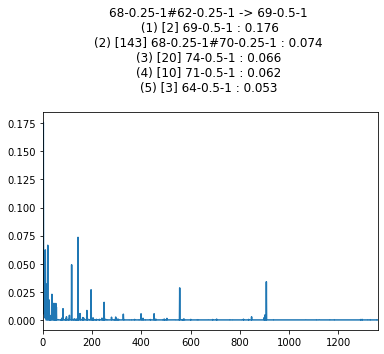

In [16]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

def predictAndPlot(beat, topn=1):
    pred, pred_beat = model.predict(beatdict, beat)

    topn = np.argsort(pred, axis=1)[:,-topn:][0]
    topn = np.flip(topn, 0)

    print(topn)

    # return topn

    window = 2000
    bound = [topn[0] - window, topn[0] + window]
    bound = np.clip(bound, 0, len(beatdict.vector_dict))

    print(bound)

    title = ''
    for index, candidate in enumerate(topn):
        target = beatdict.vector_dict[candidate]
        target_prob = round(float(pred[0, candidate]), 3)
        title += f'({index+1}) [{candidate}] {target} : {target_prob} \n'


    f, ax = plt.subplots(1)
    # ax.bar(range(bound[1]-bound[0]), pred[0, bound[0]:bound[1]])
    ax.plot(range(bound[1]-bound[0]), pred[0, bound[0]:bound[1]])
    ax.set_xlim(left=bound[0], right=bound[1])
    plt.title(f"{beat} -> {pred_beat} \n {title}")
    plt.show(f)

pick = random.sample(beatdict.vector_dict, 1)[0]
predictAndPlot(pick, topn=5)

# top_candidate_for_each_beat = []
# for beat in tqdm(beatdict.vector_dict):
#     topn = predictAndPlot(beat)
#     top_candidate_for_each_beat.append(topn[0])

# plt.bar(range(len(beatdict.vector_dict)), top_candidate_for_each_beat)
# plt.show()



In [ ]:
random.sample([10], 1)

In [ ]:
print(dataset.pitch_range_list)

In [ ]:
model = LoFiLoopNet()
model.train(x_train, y_train)
model.plot()

In [ ]:
model = LoFiLoopNet()
model.load_last_weight()

In [ ]:
model.generate(dataset)